In [74]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import median_absolute_error

import statsmodels.api as sm
from scipy.stats import zscore
from prophet import Prophet

In [75]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gauravduttakiit/peyton-manning")

print("Path to dataset files:", path)

Path to dataset files: /Users/innasnegurova/.cache/kagglehub/datasets/gauravduttakiit/peyton-manning/versions/1


In [76]:
df = pd.read_csv(path +'/example_wp_log_peyton_manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [77]:
df['ds'] = pd.to_datetime(df['ds'])
df = df.set_index('ds').squeeze()

In [78]:
df.describe()

count    2905.000000
mean        8.138958
std         0.845957
min         5.262690
25%         7.514800
50%         7.997999
75%         8.580168
max        12.846747
Name: y, dtype: float64

In [79]:
df = np.log(df)
df.head()

ds
2007-12-10    2.260800
2007-12-11    2.142368
2007-12-12    2.102142
2007-12-13    2.088459
2007-12-14    2.066049
Name: y, dtype: float64

In [80]:
df_hist = df.iloc[:-365]
df_test = df.iloc[-365:]

In [81]:
df_hist.isna().sum()

0

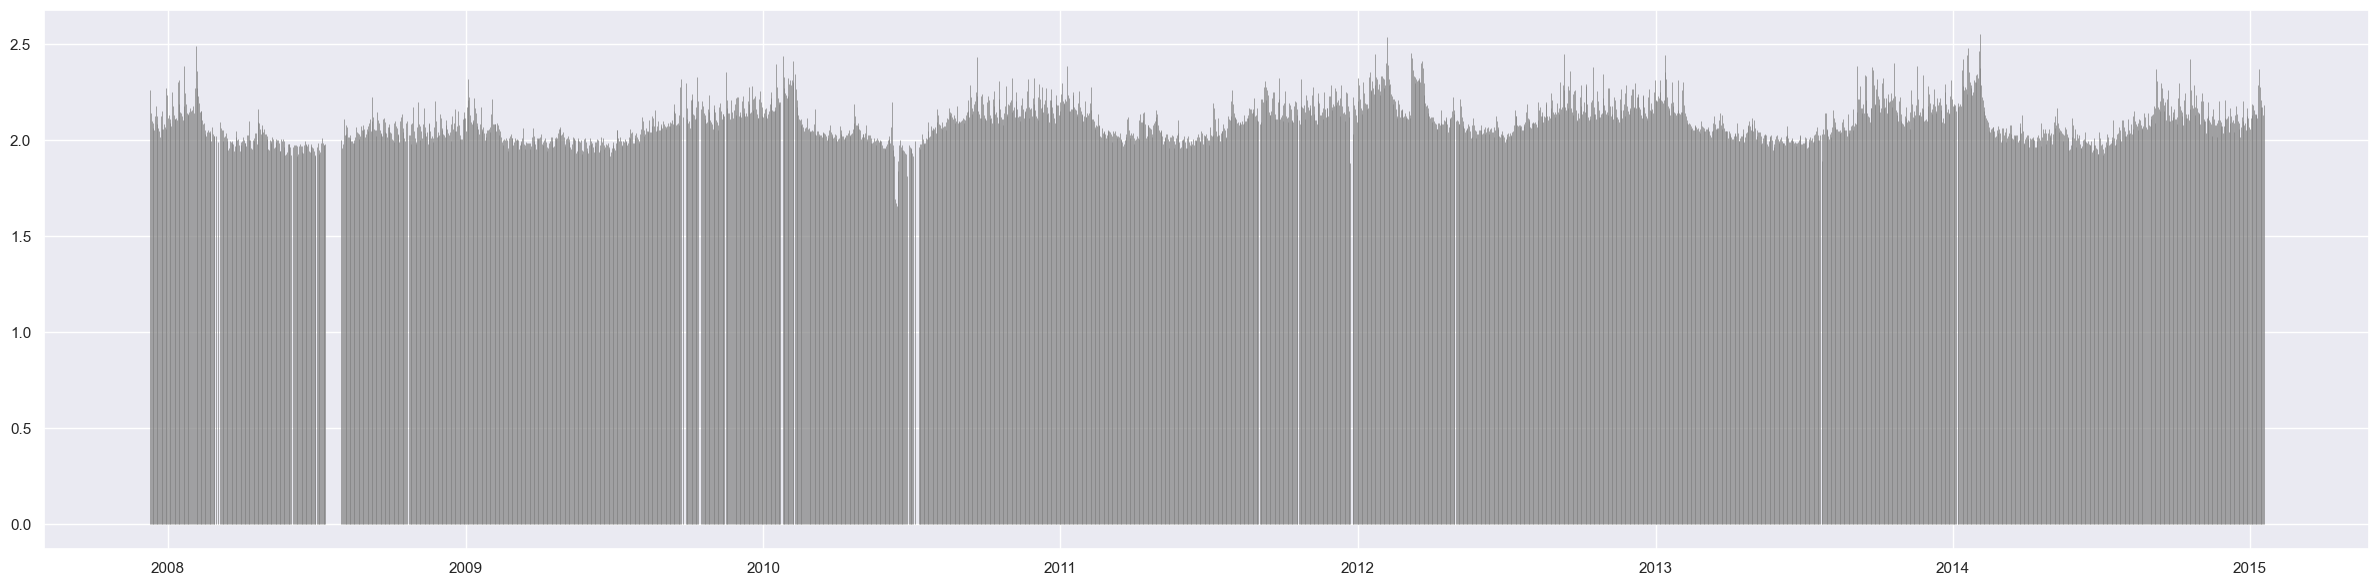

In [82]:

sns.set_theme()

fig, ax = plt.subplots(figsize=(30, 7))

ax.vlines(
    x=df_hist.index,
    ymin=0,
    ymax=df_hist,
    linewidth=0.5,
    color='grey')

In [83]:
df_hist = df_hist.asfreq('D').interpolate()
df_hist.isna().sum()

0

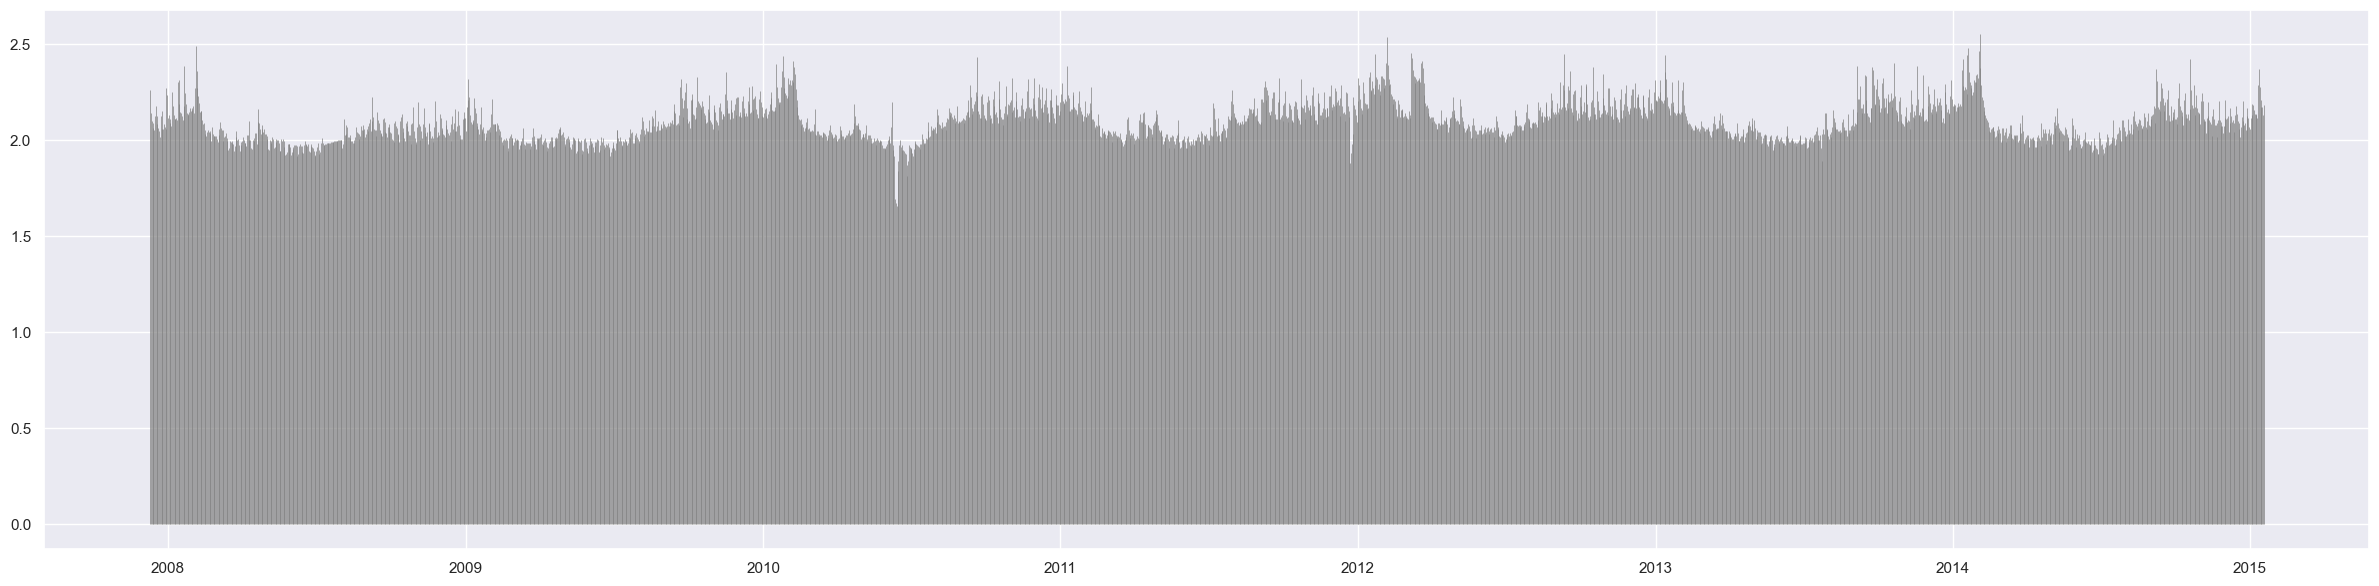

In [84]:
sns.set_theme()

fig, ax = plt.subplots(figsize=(30, 7))

ax.vlines(
    x=df_hist.index,
    ymin=0,
    ymax=df_hist,
    linewidth=0.5,
    color='grey')

<Axes: xlabel='ds', ylabel='y'>

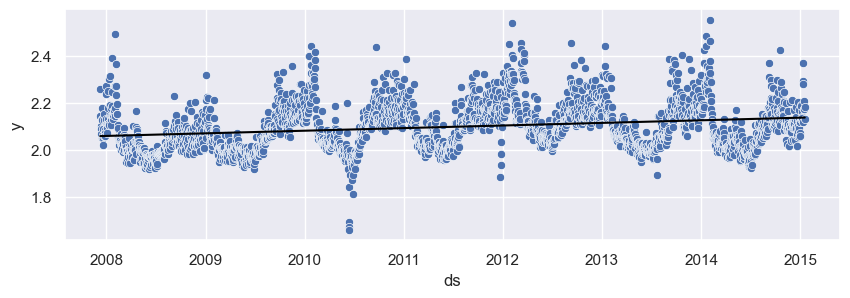

In [85]:
model = LinearRegression().fit(np.arange(len(df_hist)).reshape(-1, 1), df_hist)
trend = model.predict(np.arange(len(df_hist)).reshape(-1, 1))

ax = plt.subplots(figsize=(10, 3))
sns.scatterplot(df_hist)
sns.lineplot(y=trend, x=df_hist.index, c='black')

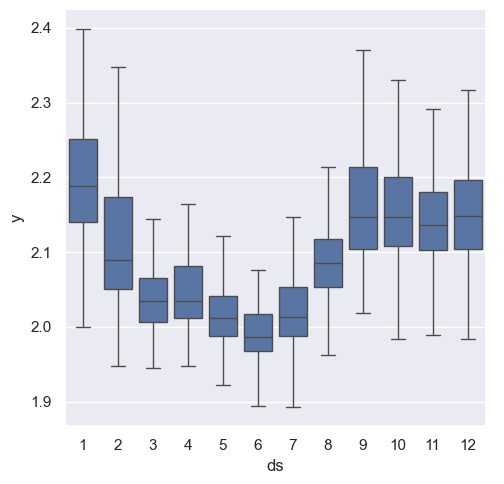

In [86]:
df_mod = df_hist - trend + trend.mean()

sns.catplot(
    y=df_hist,
    x=df_hist.index.month,
    kind='box',
    showfliers=False)

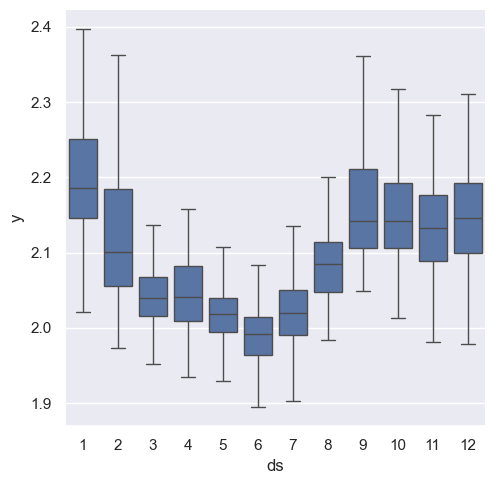

In [87]:
sns.catplot(
    y=df_mod,
    x=df_mod.index.month,
    kind='box',
    showfliers=False)

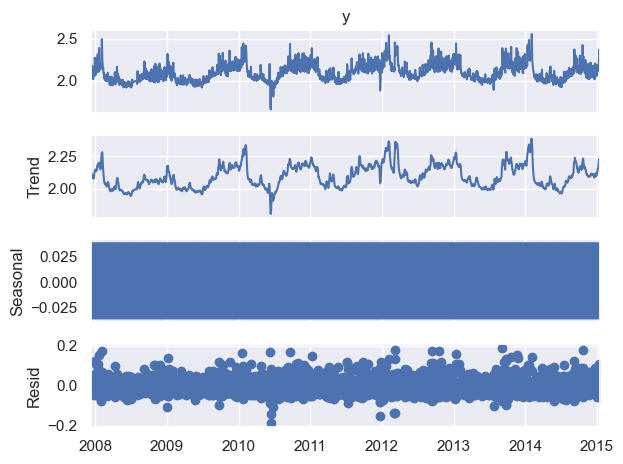

In [64]:
decomp = sm.tsa.seasonal_decompose(df_hist)
decomp_plot = decomp.plot()

In [88]:
df_zscore = zscore(decomp.resid, nan_policy='omit')

In [89]:
def zscore_adv(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z


df_zscore_adv = zscore_adv(decomp.resid, window=7)

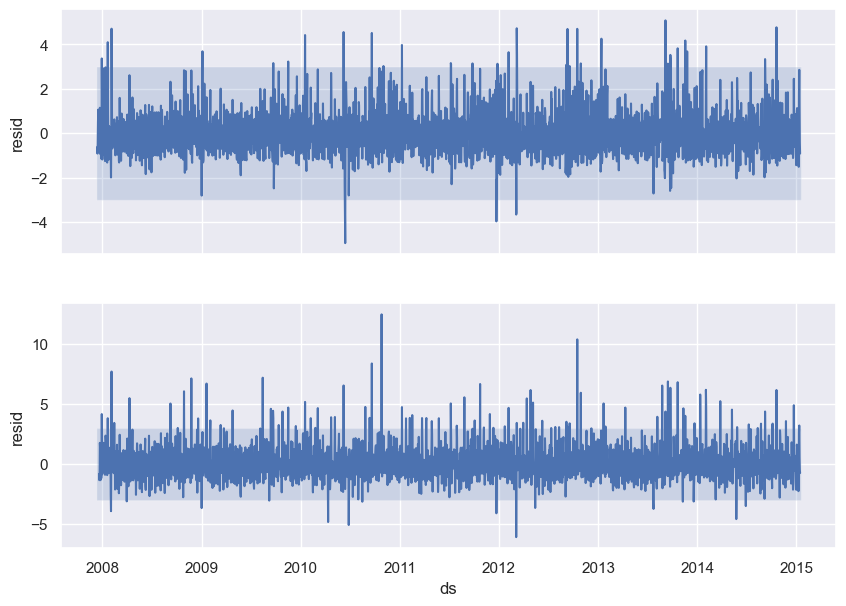

In [90]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=True,
    figsize=(10, 7))

for i, d in enumerate([df_zscore, df_zscore_adv]):
    ax = axes[i]
    sns.lineplot(d, ax=ax)
    ax.fill_between(d.index.values, -3, 3, alpha=0.2)

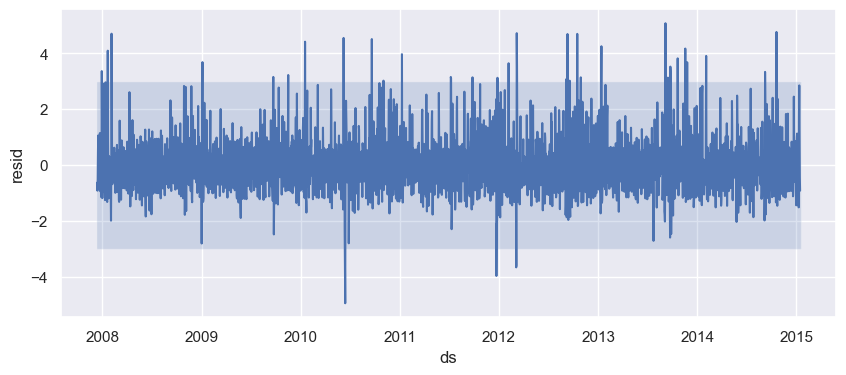

In [91]:
fig, ax = plt.subplots(
    figsize=(10, 4))

sns.lineplot(df_zscore, ax=ax)
ax.fill_between(df_zscore.index.values, -3, 3, alpha=0.2)

In [92]:
playoffs = pd.DataFrame({
    'holiday': 'playoff',
    'ds': pd.to_datetime(['2013-01-12',
                        '2014-01-12',
                          '2014-01-19',
                          '2014-02-02',
                          '2015-01-11',
                          '2016-01-17']),
    'lower_window': 0,
    'upper_window': 1})

superbowls = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2014-02-02']),
    'lower_window': 0,
    'upper_window': 1})

holidays = pd.concat((playoffs, superbowls)).reset_index(drop=True)

holidays

,holiday,ds,lower_window,upper_window
0,playoff,2013-01-12,0,1
1,playoff,2014-01-12,0,1
2,playoff,2014-01-19,0,1
3,playoff,2014-02-02,0,1
4,playoff,2015-01-11,0,1
5,playoff,2016-01-17,0,1
6,superbowl,2014-02-02,0,1


<Axes: xlabel='ds', ylabel='y'>

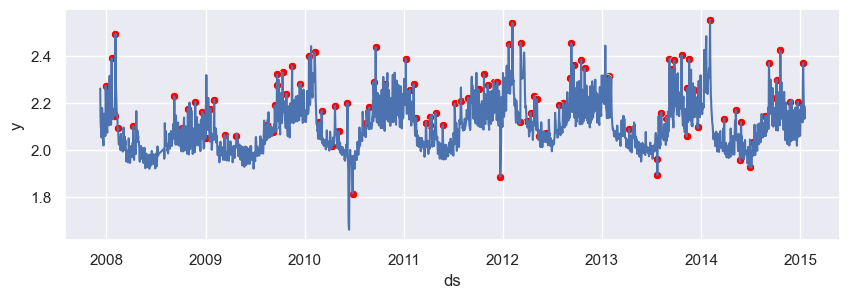

In [70]:
outliers = np.where(~df_zscore_adv.between(-3, 3) * df_zscore_adv.notna())[0]

outliers = list(set(df_hist.index[outliers]).difference(holidays['ds']))

fig, ax = plt.subplots(figsize=(10, 3))
sns.lineplot(df_hist, ax=ax)
sns.scatterplot(
    x=outliers,
    y=df_hist[outliers],
    color='red',
    ax=ax)

In [93]:
df_hist.loc[outliers] = np.nan
df_hist = df_hist.interpolate()

In [94]:
df_hist = df_hist.reset_index()

In [95]:
mp = Prophet(holidays=holidays)
mp.add_seasonality(name='yearly', period=365, fourier_order=2)
mp.fit(df_hist)

22:49:48 - cmdstanpy - INFO - Chain [1] start processing
22:49:49 - cmdstanpy - INFO - Chain [1] done processing


In [96]:
future = mp.make_future_dataframe(freq='D', periods=365)
forecast = mp.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2957,2016-01-14,2.107578,2.010260,2.207963
2958,2016-01-15,2.105294,2.013162,2.204243
2959,2016-01-16,2.079701,1.990260,2.170363
2960,2016-01-17,2.327778,2.232515,2.428103
2961,2016-01-18,2.368844,2.272772,2.464722


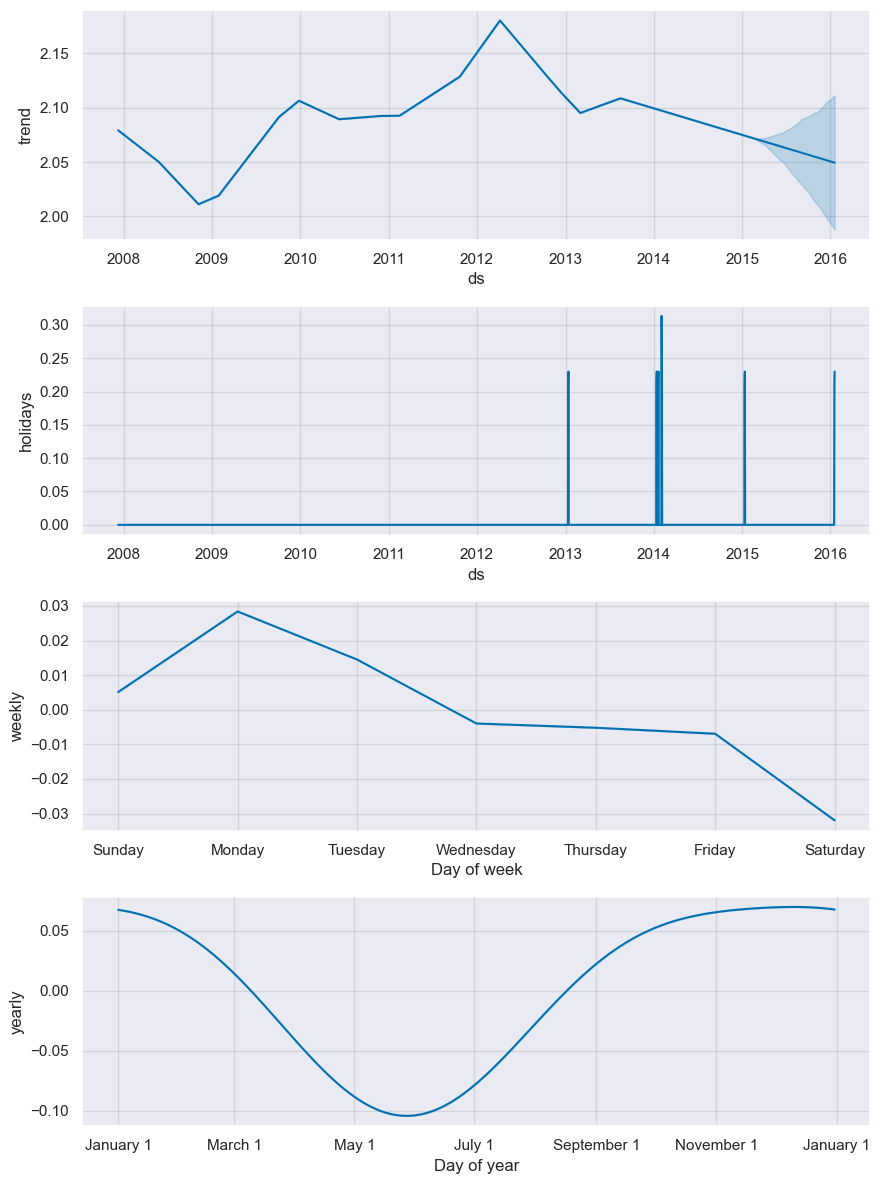

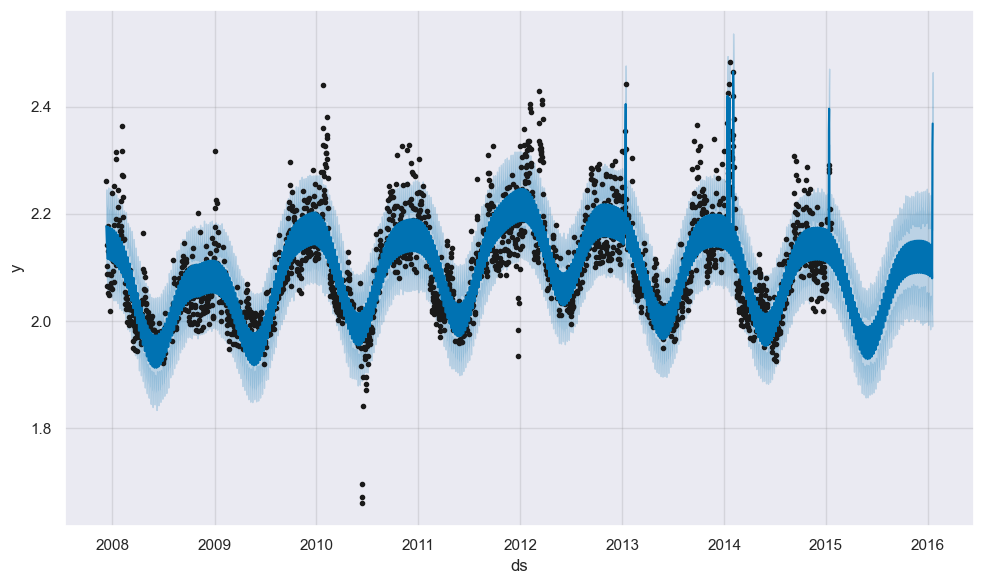

In [97]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    mp.plot_components(forecast)
    mp.plot(forecast)

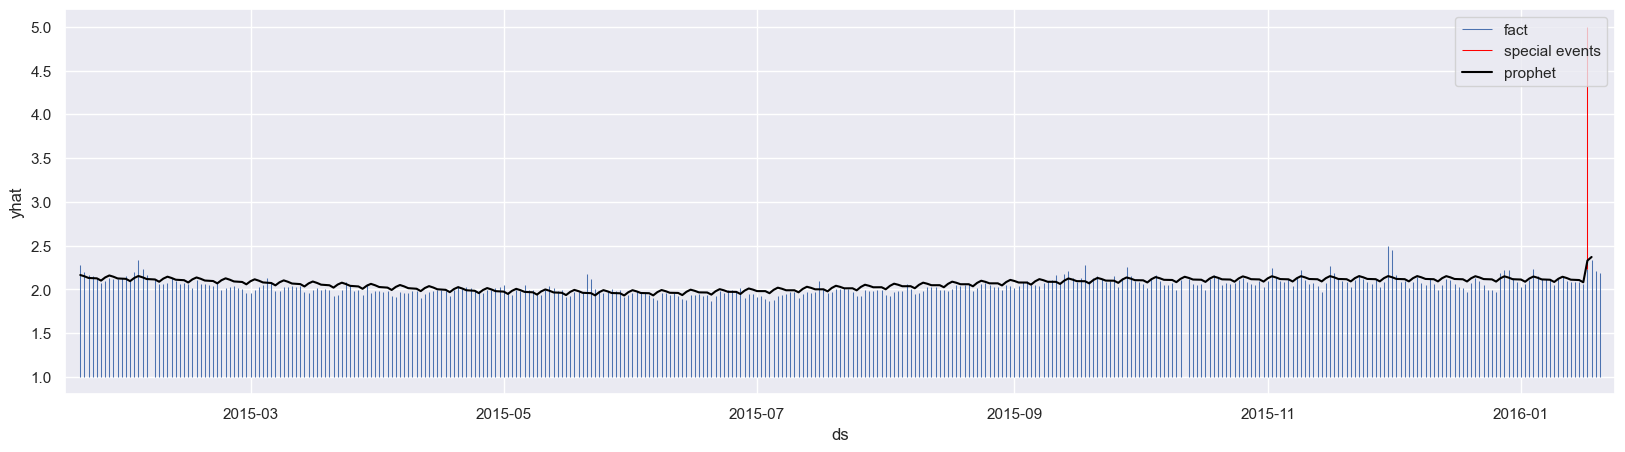

In [99]:
pred = forecast.iloc[-365:][['ds', 'yhat']]

fig, ax = plt.subplots(figsize=(20, 5))

ax.vlines(
    x=df_test.index,
    ymin=1,
    ymax=df_test,
    linewidth=0.75,
    label='fact',
    zorder=1)

ax.vlines(
    x=df_test[df_test.index.isin(holidays['ds'])].index,
    ymin=5,
    ymax=df_test[df_test.index.isin(holidays['ds'])],
    linewidth=0.75,
    color='red',
    label='special events',
    zorder=2)

sns.lineplot(data=pred, y='yhat', x='ds', c='black', label='prophet', ax=ax)

ax.margins(x=0.01)

In [100]:
approx_mape = median_absolute_error(df_test, pred['yhat'])
print(f'Accuracy: {1 - approx_mape:.1%}')

Accuracy: 95.4%
